# Imports and Hugging Face Login

In [ ]:
!pip install geopy > delete.txt
!pip install datasets > delete.txt
!pip install torch torchvision datasets > delete.txt
!pip install huggingface_hub > delete.txt
!rm delete.txt
!huggingface-cli login

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2024.10.0 requires fsspec==2024.10.0, but you have fsspec 2024.9.0 which is incompatible.

    _|    _|  _|    _|    _|_|_|    _|_|_|  _|_|_|  _|      _|    _|_|_|      _|_|_|_|    _|_|      _|_|_|  _|_|_|_|
    _|    _|  _|    _|  _|        _|          _|    _|_|    _|  _|            _|        _|    _|  _|        _|
    _|_|_|_|  _|    _|  _|  _|_|  _|  _|_|    _|    _|  _|  _|  _|  _|_|      _|_|_|    _|_|_|_|  _|        _|_|_|
    _|    _|  _|    _|  _|    _|  _|    _|    _|    _|    _|_|  _|    _|      _|        _|    _|  _|        _|
    _|    _|    _|_|      _|_|_|    _|_|_|  _|_|_|  _|      _|    _|_|_|      _|        _|    _|    _|_|_|  _|_|_|_|

    To log in, `huggingface_hub` requires a token generated from https://huggingface.co/settings/tokens .
Enter your token (input will not be visible): 
Add

In [ ]:
from datasets import load_dataset, Image
import torch
from torch import nn, optim
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms, models
import numpy as np
import matplotlib.pyplot as plt
import torchvision.transforms as transforms
from geopy.distance import geodesic
from sklearn.metrics import mean_absolute_error, mean_squared_error
import torch.nn as nn
import torch.nn.functional as F
from sklearn.utils import resample
from itertools import product
import torchvision.models as models
from timm import create_model

# Loading Datasets

In [ ]:
dataset_train = load_dataset("CIS-5190-CIA/Training_images_augmented", split="train")
dataset_test = load_dataset("CIS-5190-CIA/Testing_images_augmented", split="train")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/412 [00:00<?, ?B/s]

train-00000-of-00011.parquet:   0%|          | 0.00/486M [00:00<?, ?B/s]

train-00001-of-00011.parquet:   0%|          | 0.00/496M [00:00<?, ?B/s]

train-00002-of-00011.parquet:   0%|          | 0.00/488M [00:00<?, ?B/s]

train-00003-of-00011.parquet:   0%|          | 0.00/484M [00:00<?, ?B/s]

train-00004-of-00011.parquet:   0%|          | 0.00/484M [00:00<?, ?B/s]

train-00005-of-00011.parquet:   0%|          | 0.00/480M [00:00<?, ?B/s]

train-00006-of-00011.parquet:   0%|          | 0.00/464M [00:00<?, ?B/s]

train-00007-of-00011.parquet:   0%|          | 0.00/453M [00:00<?, ?B/s]

train-00008-of-00011.parquet:   0%|          | 0.00/462M [00:00<?, ?B/s]

train-00009-of-00011.parquet:   0%|          | 0.00/455M [00:00<?, ?B/s]

train-00010-of-00011.parquet:   0%|          | 0.00/458M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/10214 [00:00<?, ? examples/s]

README.md:   0%|          | 0.00/409 [00:00<?, ?B/s]

train-00000-of-00003.parquet:   0%|          | 0.00/445M [00:00<?, ?B/s]

train-00001-of-00003.parquet:   0%|          | 0.00/444M [00:00<?, ?B/s]

train-00002-of-00003.parquet:   0%|          | 0.00/419M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/2556 [00:00<?, ? examples/s]

In [ ]:
dataset_train = dataset_train.remove_columns(["__index_level_0__"])
dataset_test = dataset_test.remove_columns(["__index_level_0__"])

# Print the updated datasets
print(dataset_train)
print(dataset_test)

Dataset({
    features: ['Latitude', 'Longitude', 'image'],
    num_rows: 10214
})
Dataset({
    features: ['Latitude', 'Longitude', 'image'],
    num_rows: 2556
})


In [ ]:
class GPSImageDataset(Dataset):
    def __init__(self, hf_dataset, transform, lat_mean=None, lat_std=None, lon_mean=None, lon_std=None):
        self.hf_dataset = hf_dataset
        self.transform = transform

        # normalize the latitude and longitude
        self.latitudes = np.array(hf_dataset['Latitude'])
        self.longitudes = np.array(hf_dataset['Longitude'])
        self.latitude_mean = lat_mean if lat_mean is not None else self.latitudes.mean()
        self.latitude_std = lat_std if lat_std is not None else self.latitudes.std()
        self.longitude_mean = lon_mean if lon_mean is not None else self.longitudes.mean()
        self.longitude_std = lon_std if lon_std is not None else self.longitudes.std()

        self.normalized_latitudes = (self.latitudes - self.latitude_mean) / self.latitude_std
        self.normalized_longitudes = (self.longitudes - self.longitude_mean) / self.longitude_std

    def __len__(self):
        return len(self.hf_dataset)

    def __getitem__(self, idx):
        image = self.hf_dataset[idx]['image']
        latitude = self.normalized_latitudes[idx]
        longitude = self.normalized_longitudes[idx]

        if self.transform:
            image = self.transform(image)

        return image, torch.tensor([latitude, longitude], dtype=torch.float)

In [ ]:
transform = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

inference_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [ ]:
train_dataset = GPSImageDataset(hf_dataset=dataset_train, transform=transform)
train_dataloader = DataLoader(train_dataset, batch_size=16, shuffle=True)

lat_mean, lat_std = train_dataset.latitude_mean, train_dataset.latitude_std
lon_mean, lon_std = train_dataset.longitude_mean, train_dataset.longitude_std

val_dataset = GPSImageDataset(
    hf_dataset=dataset_test,
    transform=inference_transform,
    lat_mean=lat_mean,
    lat_std=lat_std,
    lon_mean=lon_mean,
    lon_std=lon_std
)
val_dataloader = DataLoader(val_dataset, batch_size=16, shuffle=False)

In [ ]:
# testing the dataloader
for images, gps_coords in train_dataloader:
    print(images.size(), gps_coords.size())
    break

torch.Size([16, 3, 224, 224]) torch.Size([16, 2])


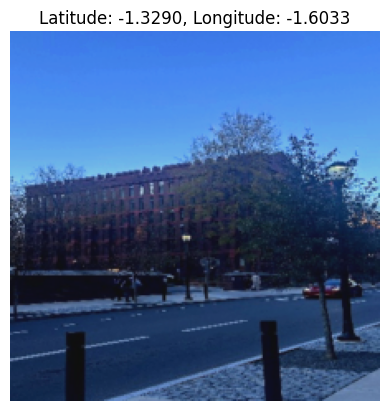

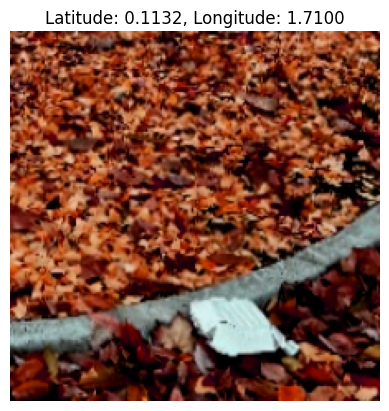

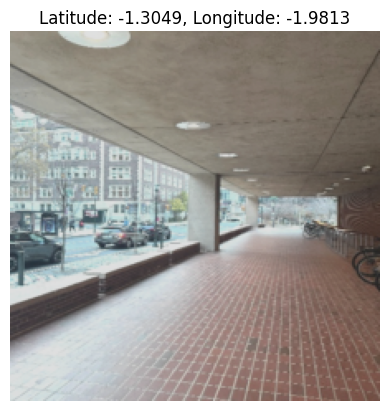

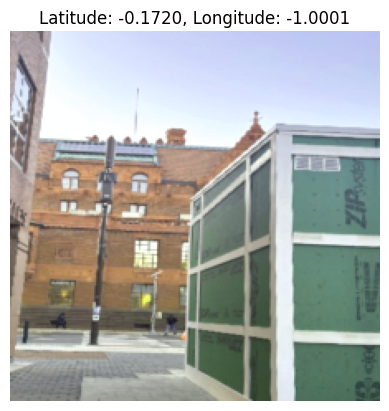

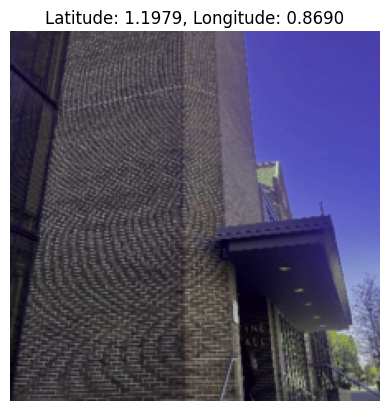

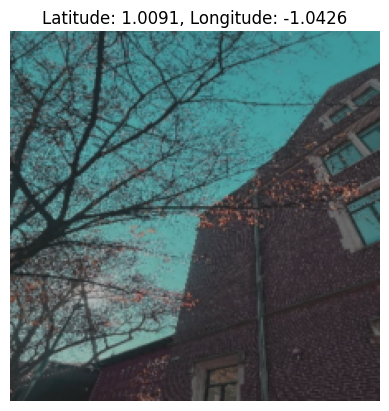

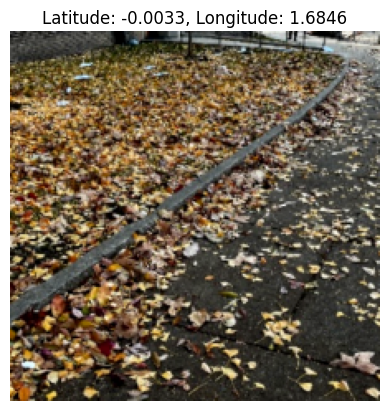

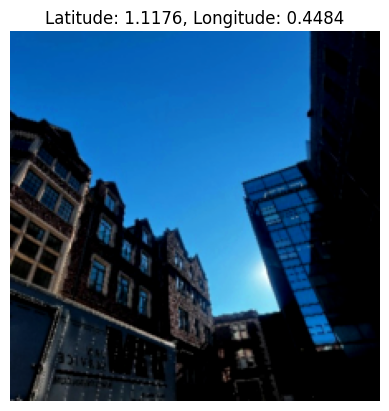

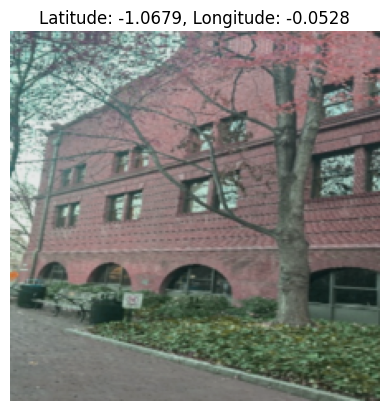

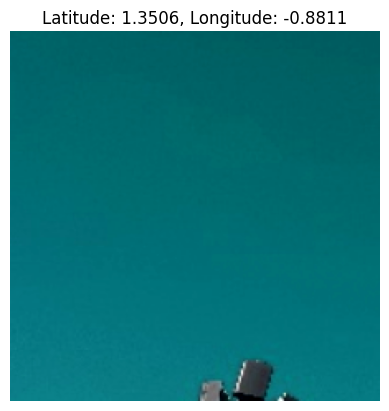

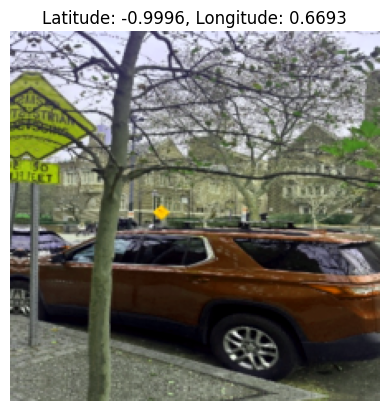

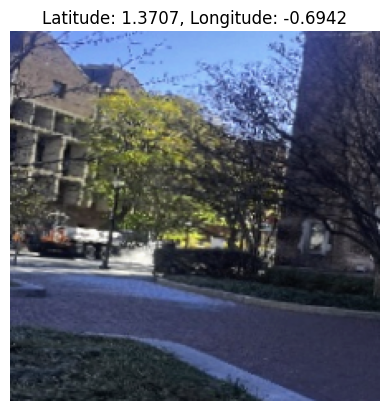

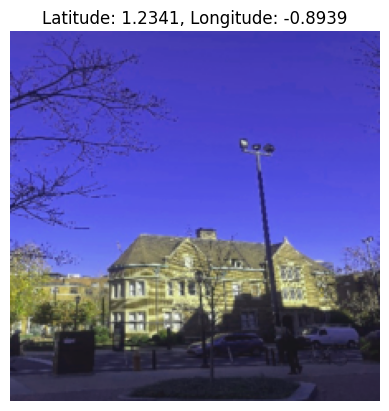

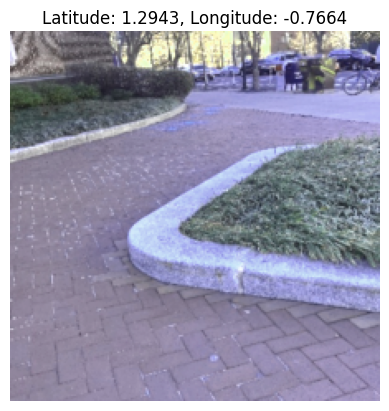

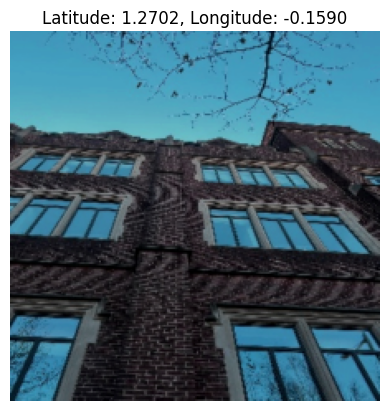

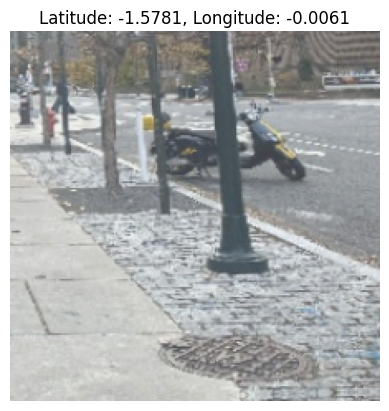

In [ ]:
def denormalize(tensor, mean, std):
    mean = np.array(mean)
    std = np.array(std)
    tensor = tensor.numpy().transpose((1, 2, 0))  # Convert from C x H x W to H x W x C
    tensor = std * tensor + mean  # Denormalize
    tensor = np.clip(tensor, 0, 1)  # Clip to keep pixel values between 0 and 1
    return tensor

data_iter = iter(train_dataloader)
images, gps_coords = next(data_iter)  # Get a batch of images and labels
# Denormalize the first image in the batch for display
itr = 0
for im in images:
  image = denormalize(im, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])

  # Plot the image
  plt.imshow(image)
  plt.title(f'Latitude: {gps_coords[itr][0].item():.4f}, Longitude: {gps_coords[itr][1].item():.4f}')
  plt.axis('off')
  plt.show()
  itr += 1

# Helper Functions

In [ ]:
def compute_baseline_metrics(dataloader, lat_mean, lon_mean, lat_std, lon_std):
    """
    Computes baseline metrics using the mean latitude and longitude as predictions.
    """
    all_targets = []
    for _, targets in dataloader:
        all_targets.append(targets)
    all_targets = torch.cat(all_targets, dim=0).cpu().numpy()

    # Denormalize targets
    actuals_denorm = all_targets * np.array([lat_std, lon_std]) + np.array([lat_mean, lon_mean])
    baseline_preds = np.array([lat_mean, lon_mean])

    baseline_loss = 0.0
    for actual in actuals_denorm:
        distance = geodesic((actual[0], actual[1]), (baseline_preds[0], baseline_preds[1])).meters
        baseline_loss += distance ** 2  # Squared geodesic distance

    baseline_loss /= len(actuals_denorm)
    baseline_rmse = np.sqrt(baseline_loss)
    return baseline_loss, baseline_rmse


def train_model_with_logging(model, train_loader, val_loader, criterion, optimizer, scheduler,
                             lat_mean, lon_mean, lat_std, lon_std, num_epochs=10, patience=5):
    """
    Trains a model and logs training/validation metrics.
    """
    model = model.to(device)

    # Compute baseline metrics
    baseline_loss, baseline_rmse = compute_baseline_metrics(val_loader, lat_mean, lon_mean, lat_std, lon_std)
    print(f"Baseline Validation Loss (meters^2): {baseline_loss:.2f}, "
          f"Baseline Validation RMSE (meters): {baseline_rmse:.2f}")

    best_rmse = float('inf')
    no_improve_epochs = 0

    # Lists to store metrics for logging
    train_losses, val_losses, val_rmses = [], [], []

    for epoch in range(num_epochs):
        print(f"\nEpoch {epoch + 1}/{num_epochs}")

        # Training phase
        model.train()
        train_loss = 0.0
        for images, targets in train_loader:
            images, targets = images.to(device), targets.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()

        train_loss /= len(train_loader)
        train_losses.append(train_loss)

        # Validation phase
        model.eval()
        val_loss = 0.0
        total_samples = 0

        with torch.no_grad():
            for images, targets in val_loader:
                images, targets = images.to(device), targets.to(device)
                outputs = model(images)

                # Denormalize predictions and targets
                preds_denorm = outputs.cpu().numpy() * np.array([lat_std, lon_std]) + np.array([lat_mean, lon_mean])
                actuals_denorm = targets.cpu().numpy() * np.array([lat_std, lon_std]) + np.array([lat_mean, lon_mean])

                # Compute geodesic distances
                for pred, actual in zip(preds_denorm, actuals_denorm):
                    distance = geodesic((actual[0], actual[1]), (pred[0], pred[1])).meters
                    val_loss += distance ** 2

                total_samples += targets.size(0)

        val_loss /= total_samples
        val_rmse = np.sqrt(val_loss)
        val_losses.append(val_loss)
        val_rmses.append(val_rmse)

        # Logging
        print(f"Train Loss (meters^2): {train_loss:.4f}, Validation Loss (meters^2): {val_loss:.4f}, "
              f"Validation RMSE (meters): {val_rmse:.4f}")

        # Early stopping and model saving
        if val_rmse < best_rmse:
            best_rmse = val_rmse
            torch.save(model.state_dict(), "best_swin_gps_model.pth")
            print("Model saved with improved RMSE!")
            no_improve_epochs = 0
        else:
            no_improve_epochs += 1

        if no_improve_epochs >= patience:
            print("Early stopping triggered!")
            break

        # Step the scheduler
        scheduler.step()

    # Final metrics logging
    print(f"\nTraining complete! Best Validation RMSE: {best_rmse:.4f} meters.")
    return train_losses, val_losses, val_rmses

In [ ]:
def plot_metrics(train_losses, val_losses, val_rmses):
    """
    Plots training/validation loss and RMSE metrics.
    """
    plt.figure(figsize=(12, 6))

    # Loss Plot
    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label="Train Loss (m²)")
    plt.plot(val_losses, label="Validation Loss (m²)")
    plt.xlabel("Epoch")
    plt.ylabel("Loss (m²)")
    plt.title("Loss During Training")
    plt.legend()

    # RMSE Plot
    plt.subplot(1, 2, 2)
    plt.plot(val_rmses, label="Validation RMSE (m)")
    plt.xlabel("Epoch")
    plt.ylabel("RMSE (m)")
    plt.title("Validation RMSE")
    plt.legend()

    plt.tight_layout()
    plt.show()

# Model

In [ ]:
!pip install timm torch torchvision matplotlib

In [ ]:
class SwinGPSModel(nn.Module):
    def __init__(self, pretrained=True):
        super(SwinGPSModel, self).__init__()
        # Load the pretrained Swin Transformer
        self.backbone = create_model('swin_base_patch4_window7_224', pretrained=pretrained)

        # Get the number of features from the backbone
        num_features = self.backbone.num_features
        self.backbone.head = nn.Identity()

        # Define the regression head
        self.regression_head = nn.Sequential(
            nn.AdaptiveAvgPool2d((1, 1)),
            nn.Flatten(),
            nn.Linear(num_features, 256),
            nn.ReLU(),
            nn.Linear(256, 2)
        )

    def forward(self, x):
        # Forward pass through the backbone
        features = self.backbone(x)
        features = features.permute(0, 3, 1, 2)
        return self.regression_head(features)

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Initialize the model
model = SwinGPSModel(pretrained=True)
model.to(device)

# Define the optimizer
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-2)

# Define the learning rate scheduler
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=10)

# Define the loss function (MSE for regression)
criterion = nn.MSELoss()

model.safetensors:   0%|          | 0.00/353M [00:00<?, ?B/s]

Baseline Validation Loss (meters^2): 8942.54, Baseline Validation RMSE (meters): 94.56

Epoch 1/25
Train Loss (meters^2): 0.2628, Validation Loss (meters^2): 661.7406, Validation RMSE (meters): 25.7243
Model saved with improved RMSE!

Epoch 2/25


/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:224: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn(


Train Loss (meters^2): 0.1156, Validation Loss (meters^2): 792.4835, Validation RMSE (meters): 28.1511

Epoch 3/25
Train Loss (meters^2): 0.1075, Validation Loss (meters^2): 350.5723, Validation RMSE (meters): 18.7236
Model saved with improved RMSE!

Epoch 4/25
Train Loss (meters^2): 0.0909, Validation Loss (meters^2): 883.2599, Validation RMSE (meters): 29.7197

Epoch 5/25
Train Loss (meters^2): 0.0823, Validation Loss (meters^2): 257.9136, Validation RMSE (meters): 16.0597
Model saved with improved RMSE!

Epoch 6/25
Train Loss (meters^2): 0.0724, Validation Loss (meters^2): 363.3126, Validation RMSE (meters): 19.0608

Epoch 7/25
Train Loss (meters^2): 0.0936, Validation Loss (meters^2): 285.0426, Validation RMSE (meters): 16.8832

Epoch 8/25
Train Loss (meters^2): 0.0785, Validation Loss (meters^2): 313.1825, Validation RMSE (meters): 17.6970

Epoch 9/25
Train Loss (meters^2): 0.0696, Validation Loss (meters^2): 249.3578, Validation RMSE (meters): 15.7911
Model saved with improved RM

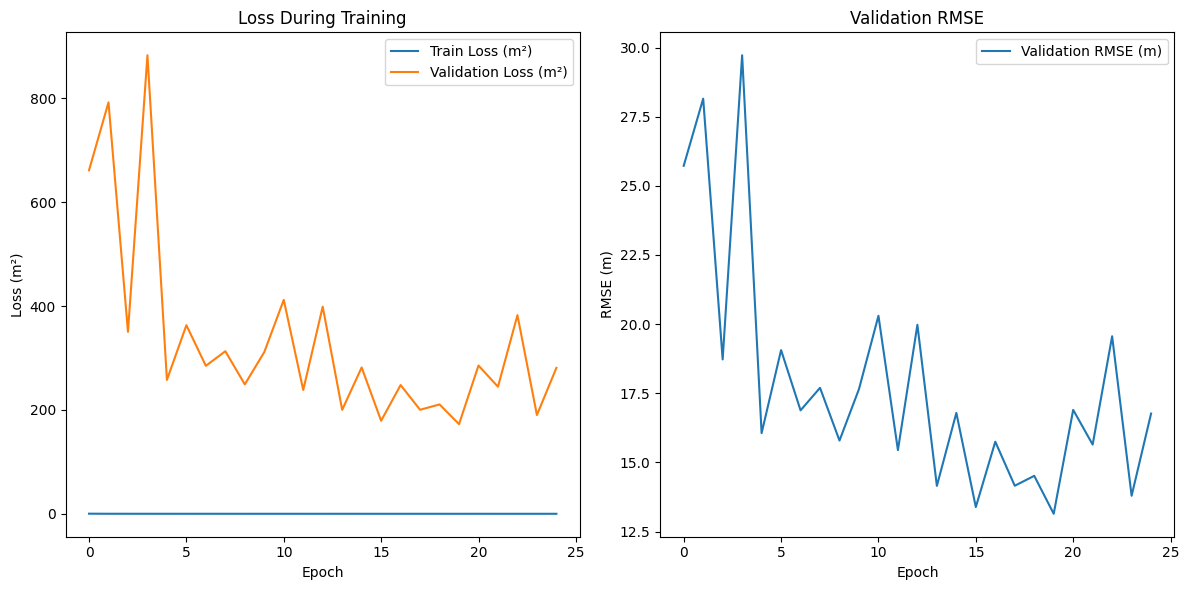

In [ ]:
train_losses, val_losses, val_rmses = train_model_with_logging(
    model=model,
    train_loader=train_dataloader,
    val_loader=val_dataloader,
    criterion=nn.MSELoss(),
    optimizer=torch.optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-2),
    scheduler=torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=10),
    lat_mean=lat_mean, lon_mean=lon_mean, lat_std=lat_std, lon_std=lon_std,
    num_epochs=25, patience=5
)

# Plot training metrics
plot_metrics(train_losses, val_losses, val_rmses)

In [ ]:
print (lat_mean, lon_mean, lat_std, lon_std)

39.9517411499467 -75.19143213125122 0.0006914493505038013 0.0006539239061573955


# Visualization

In [ ]:
def visualize_predictions(all_preds, all_actuals, lat_mean, lon_mean, lat_std, lon_std):
    """
    Visualizes actual and predicted GPS coordinates on a scatter plot,
    including error lines connecting each prediction to its corresponding actual point.
    """
    all_preds_denorm = all_preds * np.array([lat_std, lon_std]) + np.array([lat_mean, lon_mean])
    all_actuals_denorm = all_actuals * np.array([lat_std, lon_std]) + np.array([lat_mean, lon_mean])


    plt.figure(figsize=(10, 5))
    plt.scatter(all_actuals_denorm[:, 1], all_actuals_denorm[:, 0], label='Actual', color='blue', alpha=0.6)
    plt.scatter(all_preds_denorm[:, 1], all_preds_denorm[:, 0], label='Predicted', color='red', alpha=0.6)
    for i in range(len(all_actuals_denorm)):
        plt.plot(
            [all_actuals_denorm[i, 1], all_preds_denorm[i, 1]],
            [all_actuals_denorm[i, 0], all_preds_denorm[i, 0]],
            color='gray', linewidth=0.5
        )

    plt.legend()
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    plt.title('Actual vs. Predicted GPS Coordinates with Error Lines')
    plt.grid(True)
    plt.show()

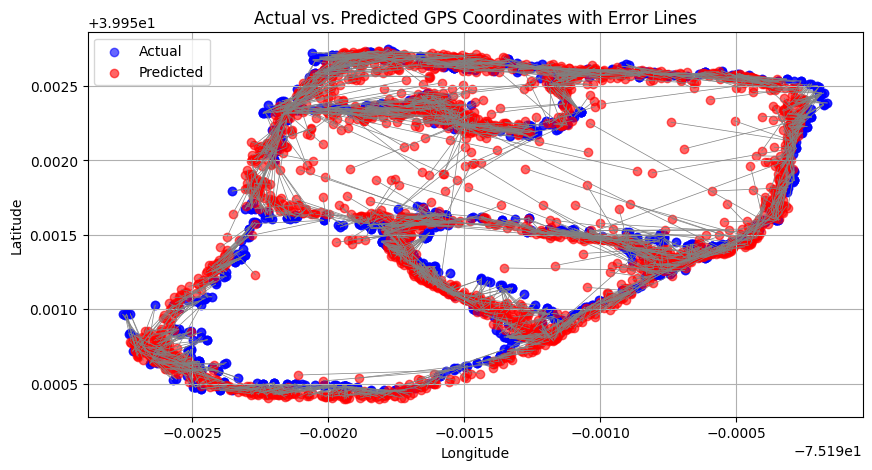

In [ ]:
model.eval()

all_preds = []
all_actuals = []

with torch.no_grad():
    for images, targets in val_dataloader:
        images = images.to(device)
        targets = targets.to(device)

        preds = model(images)

        all_preds.append(preds.cpu().numpy())
        all_actuals.append(targets.cpu().numpy())

all_preds = np.concatenate(all_preds, axis=0)
all_actuals = np.concatenate(all_actuals, axis=0)

# Visualize predictions vs actuals
visualize_predictions(
    all_preds=all_preds,
    all_actuals=all_actuals,
    lat_mean=lat_mean,
    lon_mean=lon_mean,
    lat_std=lat_std,
    lon_std=lon_std
)